# 자율주행 보조장치
- 조건에 따라 Go와 Stop을 결정하기
![1](https://github.com/user-attachments/assets/e33a7030-e0eb-408b-a79b-91b4d122c098)

In [1]:
import os, copy
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

DATA_PATH = os.getenv('HOME') + '/aiffel/object_detection/data'

### 데이터셋 다운로드 및 확인

In [2]:
(ds_train, ds_test), ds_info = tfds.load(
    'kitti',
    data_dir=DATA_PATH,
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

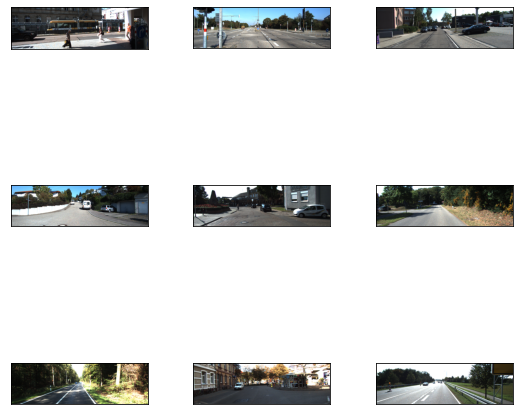

In [3]:
_ = tfds.show_examples(ds_train, ds_info)

In [4]:
ds_info

tfds.core.DatasetInfo(
    name='kitti',
    full_name='kitti/3.2.0',
    description="""
    Kitti contains a suite of vision tasks built using an autonomous driving
    platform. The full benchmark contains many tasks such as stereo, optical flow,
    visual odometry, etc. This dataset contains the object detection dataset,
    including the monocular images and bounding boxes. The dataset contains 7481
    training images annotated with 3D bounding boxes. A full description of the
    annotations can be found in the readme of the object development kit readme on
    the Kitti homepage.
    """,
    homepage='http://www.cvlibs.net/datasets/kitti/',
    data_path='/aiffel/aiffel/object_detection/data/kitti/3.2.0',
    download_size=11.71 GiB,
    dataset_size=5.27 GiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/file_name': Text(shape=(), dtype=tf.string),
        'objects': Sequence({
            'alpha': tf.float32,
     

------Example------
['image', 'image/file_name', 'objects']
------objects------
{'alpha': <tf.Tensor: shape=(4,), dtype=float32, numpy=array([-1.58,  2.08,  1.78, -1.51], dtype=float32)>, 'bbox': <tf.Tensor: shape=(4, 4), dtype=float32, numpy=
array([[0.47138667, 0.47376007, 0.5426667 , 0.4955314 ],
       [0.26789334, 0.0534219 , 0.5182667 , 0.20785025],
       [0.45277333, 0.32633656, 0.54642665, 0.366562  ],
       [0.47277334, 0.43785828, 0.54112   , 0.45958132]], dtype=float32)>, 'dimensions': <tf.Tensor: shape=(4, 3), dtype=float32, numpy=
array([[1.65, 1.67, 3.64],
       [1.68, 1.67, 3.87],
       [1.87, 1.8 , 4.72],
       [1.61, 1.51, 4.5 ]], dtype=float32)>, 'location': <tf.Tensor: shape=(4, 3), dtype=float32, numpy=
array([[ -0.57,   1.59,  46.82],
       [ -9.09,   1.85,  14.99],
       [-10.22,   1.76,  41.23],
       [ -3.5 ,   1.6 ,  48.14]], dtype=float32)>, 'occluded': <tf.Tensor: shape=(4,), dtype=int64, numpy=array([0, 1, 1, 0])>, 'rotation_y': <tf.Tensor: shape=(4,

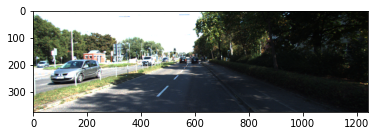

In [5]:
sample = ds_train.take(1)

for example in sample:  
    print('------Example------')
    print(list(example.keys()))
    image = example["image"]
    filename = example["image/file_name"].numpy().decode('utf-8')
    objects = example["objects"]

print('------objects------')
print(objects)

img = Image.fromarray(image.numpy())
plt.imshow(img)
plt.show()

### 바운딩박스 시각화

In [6]:
def visualize_bbox(input_image, object_bbox):
    input_image = copy.deepcopy(input_image)
    draw = ImageDraw.Draw(input_image)
    
    # 바운딩 박스 좌표(x_min, x_max, y_min, y_max) 구하기
    width, height = img.size
    x_min = object_bbox[:,1] * width
    x_max = object_bbox[:,3] * width
    y_min = height - object_bbox[:,0] * height
    y_max = height - object_bbox[:,2] * height
    
    # 바운딩 박스 그리기
    rects = np.stack([x_min, y_min, x_max, y_max], axis=1)
    for _rect in rects:
        draw.rectangle(_rect, outline=(255,0,0), width=2)

    return input_image

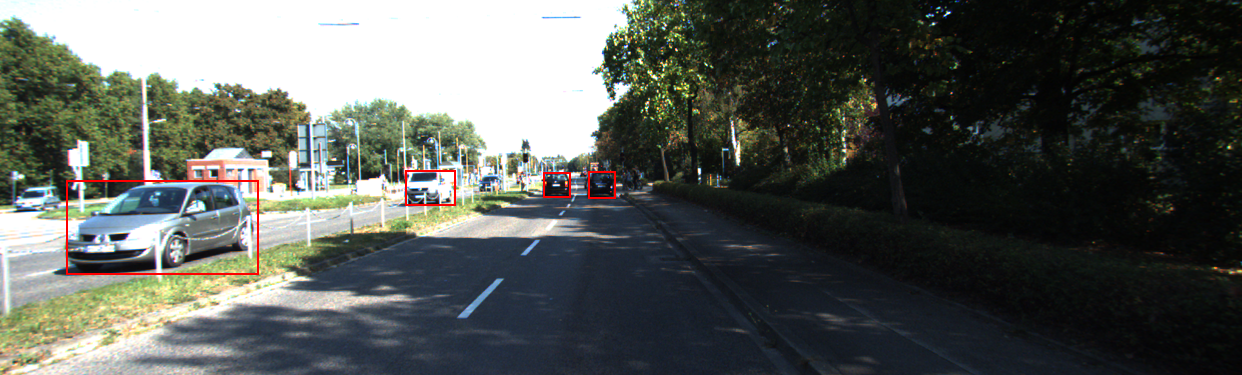

In [7]:
visualize_bbox(img, objects['bbox'].numpy())

### 데이터 파이프라인
- x, y좌표 위치 교체
- 무작위 수평 flip
- 이미지 크기 조정 및 패딩
- minmax에서 width, height로 수정

In [8]:
def swap_xy(boxes):
    return tf.stack([boxes[:, 1], boxes[:, 0], boxes[:, 3], boxes[:, 2]], axis=-1)

def random_flip_horizontal(image, boxes):
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        boxes = tf.stack(
           [1 - boxes[:, 2], boxes[:, 1], 1 - boxes[:, 0], boxes[:, 3]], axis=-1
        )
        
    return image, boxes

def resize_and_pad_image(image, training=True):

    min_side = 800.0
    max_side = 1333.0
    min_side_range = [640, 1024]
    stride = 128.0
    
    image_shape = tf.cast(tf.shape(image)[:2], dtype=tf.float32)
    if training:
        min_side = tf.random.uniform((), min_side_range[0], min_side_range[1], dtype=tf.float32)
    ratio = min_side / tf.reduce_min(image_shape)
    if ratio * tf.reduce_max(image_shape) > max_side:
        ratio = max_side / tf.reduce_max(image_shape)
    image_shape = ratio * image_shape
    image = tf.image.resize(image, tf.cast(image_shape, dtype=tf.int32))
    padded_image_shape = tf.cast(
        tf.math.ceil(image_shape / stride) * stride, dtype=tf.int32
    )
    image = tf.image.pad_to_bounding_box(
        image, 0, 0, padded_image_shape[0], padded_image_shape[1]
    )
    return image, image_shape, ratio

def convert_to_xywh(boxes):
    return tf.concat(
        [(boxes[..., :2] + boxes[..., 2:]) / 2.0, boxes[..., 2:] - boxes[..., :2]],
        axis=-1,
    )

In [9]:
def preprocess_data(sample):
    image = sample["image"]
    bbox = swap_xy(sample["objects"]["bbox"])
    class_id = tf.cast(sample["objects"]["type"], dtype=tf.int32)

    image, bbox = random_flip_horizontal(image, bbox)
    image, image_shape, _ = resize_and_pad_image(image)

    bbox = tf.stack(
        [
            bbox[:, 0] * image_shape[1],
            bbox[:, 1] * image_shape[0],
            bbox[:, 2] * image_shape[1],
            bbox[:, 3] * image_shape[0],
        ],
        axis=-1,
    )
    bbox = convert_to_xywh(bbox)
    return image, bbox, class_id

### 인코딩
- retina net의 FPN(특징 피라미드 네트워크)를 위한 anchor box 생성
![1](https://github.com/user-attachments/assets/fbe42b93-4aa6-43e0-9858-949342d41cdc)

In [10]:
class AnchorBox:
    def __init__(self):
        self.aspect_ratios = [0.5, 1.0, 2.0]
        self.scales = [2 ** x for x in [0, 1 / 3, 2 / 3]]

        self._num_anchors = len(self.aspect_ratios) * len(self.scales)
        self._strides = [2 ** i for i in range(3, 8)]
        self._areas = [x ** 2 for x in [32.0, 64.0, 128.0, 256.0, 512.0]]
        self._anchor_dims = self._compute_dims()

    def _compute_dims(self):
        anchor_dims_all = []
        for area in self._areas:
            anchor_dims = []
            for ratio in self.aspect_ratios:
                anchor_height = tf.math.sqrt(area / ratio)
                anchor_width = area / anchor_height
                dims = tf.reshape(
                    tf.stack([anchor_width, anchor_height], axis=-1), [1, 1, 2]
                )
                for scale in self.scales:
                    anchor_dims.append(scale * dims)
            anchor_dims_all.append(tf.stack(anchor_dims, axis=-2))
        return anchor_dims_all

    def _get_anchors(self, feature_height, feature_width, level):
        rx = tf.range(feature_width, dtype=tf.float32) + 0.5
        ry = tf.range(feature_height, dtype=tf.float32) + 0.5
        centers = tf.stack(tf.meshgrid(rx, ry), axis=-1) * self._strides[level - 3]
        centers = tf.expand_dims(centers, axis=-2)
        centers = tf.tile(centers, [1, 1, self._num_anchors, 1])
        dims = tf.tile(
            self._anchor_dims[level - 3], [feature_height, feature_width, 1, 1]
        )
        anchors = tf.concat([centers, dims], axis=-1)
        return tf.reshape(
            anchors, [feature_height * feature_width * self._num_anchors, 4]
        )

    def get_anchors(self, image_height, image_width):
        anchors = [
            self._get_anchors(
                tf.math.ceil(image_height / 2 ** i),
                tf.math.ceil(image_width / 2 ** i),
                i,
            )
            for i in range(3, 8)
        ]
        return tf.concat(anchors, axis=0)

### anchor box에 맞게 데이터를 변형
- iou를 통해 anchor box를 판단

In [11]:
def convert_to_corners(boxes):
    return tf.concat(
        [boxes[..., :2] - boxes[..., 2:] / 2.0, boxes[..., :2] + boxes[..., 2:] / 2.0],
        axis=-1,
    )

def compute_iou(boxes1, boxes2):
    boxes1_corners = convert_to_corners(boxes1)
    boxes2_corners = convert_to_corners(boxes2)
    lu = tf.maximum(boxes1_corners[:, None, :2], boxes2_corners[:, :2])
    rd = tf.minimum(boxes1_corners[:, None, 2:], boxes2_corners[:, 2:])
    intersection = tf.maximum(0.0, rd - lu)
    intersection_area = intersection[:, :, 0] * intersection[:, :, 1]
    boxes1_area = boxes1[:, 2] * boxes1[:, 3]
    boxes2_area = boxes2[:, 2] * boxes2[:, 3]
    union_area = tf.maximum(
        boxes1_area[:, None] + boxes2_area - intersection_area, 1e-8
    )
    return tf.clip_by_value(intersection_area / union_area, 0.0, 1.0)

In [12]:
class LabelEncoder:

    def __init__(self):
        self._anchor_box = AnchorBox()
        self._box_variance = tf.convert_to_tensor(
            [0.1, 0.1, 0.2, 0.2], dtype=tf.float32
        )

    def _match_anchor_boxes(
        self, anchor_boxes, gt_boxes, match_iou=0.5, ignore_iou=0.4
    ):
        iou_matrix = compute_iou(anchor_boxes, gt_boxes)
        max_iou = tf.reduce_max(iou_matrix, axis=1)
        matched_gt_idx = tf.argmax(iou_matrix, axis=1)
        positive_mask = tf.greater_equal(max_iou, match_iou)
        negative_mask = tf.less(max_iou, ignore_iou)
        ignore_mask = tf.logical_not(tf.logical_or(positive_mask, negative_mask))
        return (
            matched_gt_idx,
            tf.cast(positive_mask, dtype=tf.float32),
            tf.cast(ignore_mask, dtype=tf.float32),
        )

    def _compute_box_target(self, anchor_boxes, matched_gt_boxes):
        box_target = tf.concat(
            [
                (matched_gt_boxes[:, :2] - anchor_boxes[:, :2]) / anchor_boxes[:, 2:],
                tf.math.log(matched_gt_boxes[:, 2:] / anchor_boxes[:, 2:]),
            ],
            axis=-1,
        )
        box_target = box_target / self._box_variance
        return box_target

    def _encode_sample(self, image_shape, gt_boxes, cls_ids):
        anchor_boxes = self._anchor_box.get_anchors(image_shape[1], image_shape[2])
        cls_ids = tf.cast(cls_ids, dtype=tf.float32)
        matched_gt_idx, positive_mask, ignore_mask = self._match_anchor_boxes(
            anchor_boxes, gt_boxes
        )
        matched_gt_boxes = tf.gather(gt_boxes, matched_gt_idx)
        box_target = self._compute_box_target(anchor_boxes, matched_gt_boxes)
        matched_gt_cls_ids = tf.gather(cls_ids, matched_gt_idx)
        cls_target = tf.where(
            tf.not_equal(positive_mask, 1.0), -1.0, matched_gt_cls_ids
        )
        cls_target = tf.where(tf.equal(ignore_mask, 1.0), -2.0, cls_target)
        cls_target = tf.expand_dims(cls_target, axis=-1)
        label = tf.concat([box_target, cls_target], axis=-1)
        return label

    def encode_batch(self, batch_images, gt_boxes, cls_ids):
        images_shape = tf.shape(batch_images)
        batch_size = images_shape[0]

        labels = tf.TensorArray(dtype=tf.float32, size=batch_size, dynamic_size=True)
        for i in range(batch_size):
            label = self._encode_sample(images_shape, gt_boxes[i], cls_ids[i])
            labels = labels.write(i, label)
        batch_images = tf.keras.applications.resnet.preprocess_input(batch_images)
        return batch_images, labels.stack()

### FPN(Feature Pyramid Network)
- 약간 수정된 피라미드 사용

In [13]:
class FeaturePyramid(tf.keras.layers.Layer):

    def __init__(self, backbone):
        super(FeaturePyramid, self).__init__(name="FeaturePyramid")
        self.backbone = backbone
        self.conv_c3_1x1 = tf.keras.layers.Conv2D(256, 1, 1, "same")
        self.conv_c4_1x1 = tf.keras.layers.Conv2D(256, 1, 1, "same")
        self.conv_c5_1x1 = tf.keras.layers.Conv2D(256, 1, 1, "same")
        self.conv_c3_3x3 = tf.keras.layers.Conv2D(256, 3, 1, "same")
        self.conv_c4_3x3 = tf.keras.layers.Conv2D(256, 3, 1, "same")
        self.conv_c5_3x3 = tf.keras.layers.Conv2D(256, 3, 1, "same")
        self.conv_c6_3x3 = tf.keras.layers.Conv2D(256, 3, 2, "same")
        self.conv_c7_3x3 = tf.keras.layers.Conv2D(256, 3, 2, "same")
        self.upsample_2x = tf.keras.layers.UpSampling2D(2)

    def call(self, images, training=False):
        c3_output, c4_output, c5_output = self.backbone(images, training=training)
        p3_output = self.conv_c3_1x1(c3_output)
        p4_output = self.conv_c4_1x1(c4_output)
        p5_output = self.conv_c5_1x1(c5_output)
        p4_output = p4_output + self.upsample_2x(p5_output)
        p3_output = p3_output + self.upsample_2x(p4_output)
        p3_output = self.conv_c3_3x3(p3_output)
        p4_output = self.conv_c4_3x3(p4_output)
        p5_output = self.conv_c5_3x3(p5_output)
        p6_output = self.conv_c6_3x3(c5_output)
        p7_output = self.conv_c7_3x3(tf.nn.relu(p6_output))
        return p3_output, p4_output, p5_output, p6_output, p7_output

In [14]:
def build_head(output_filters, bias_init):
    head = tf.keras.Sequential([tf.keras.Input(shape=[None, None, 256])])
    kernel_init = tf.initializers.RandomNormal(0.0, 0.01)
    for _ in range(4):
        head.add(
            tf.keras.layers.Conv2D(256, 3, padding="same", kernel_initializer=kernel_init)
        )
        head.add(tf.keras.layers.ReLU())
    head.add(
        tf.keras.layers.Conv2D(
            output_filters,
            3,
            1,
            padding="same",
            kernel_initializer=kernel_init,
            bias_initializer=bias_init,
        )
    )
    return head

retina net의 백본 네트워크(resnet50)

In [15]:
def get_backbone():
    backbone = tf.keras.applications.ResNet50(
        include_top=False, input_shape=[None, None, 3]
    )
    c3_output, c4_output, c5_output = [
        backbone.get_layer(layer_name).output
        for layer_name in ["conv3_block4_out", "conv4_block6_out", "conv5_block3_out"]
    ]
    return tf.keras.Model(
        inputs=[backbone.inputs], outputs=[c3_output, c4_output, c5_output]
    )

retina net 작성

In [16]:
class RetinaNet(tf.keras.Model):

    def __init__(self, num_classes, backbone):
        super(RetinaNet, self).__init__(name="RetinaNet")
        self.fpn = FeaturePyramid(backbone)
        self.num_classes = num_classes

        prior_probability = tf.constant_initializer(-np.log((1 - 0.01) / 0.01))
        self.cls_head = build_head(9 * num_classes, prior_probability)
        self.box_head = build_head(9 * 4, "zeros")

    def call(self, image, training=False):
        features = self.fpn(image, training=training)
        N = tf.shape(image)[0]
        cls_outputs = []
        box_outputs = []
        for feature in features:
            box_outputs.append(tf.reshape(self.box_head(feature), [N, -1, 4]))
            cls_outputs.append(
                tf.reshape(self.cls_head(feature), [N, -1, self.num_classes])
            )
        cls_outputs = tf.concat(cls_outputs, axis=1)
        box_outputs = tf.concat(box_outputs, axis=1)
        return tf.concat([box_outputs, cls_outputs], axis=-1)

### loss function
- focal loss와 smooth L1 loss사용
    - classification : focal loss
        - alpha와 gamma를 사용해서 물체와 배경의 식이 달라짐
    - box regression : smooth L1 loss
        - delta를 기준으로 계산이 달라짐

In [17]:
class RetinaNetBoxLoss(tf.losses.Loss):

    def __init__(self, delta):
        super(RetinaNetBoxLoss, self).__init__(
            reduction="none", name="RetinaNetBoxLoss"
        )
        self._delta = delta

    def call(self, y_true, y_pred):
        difference = y_true - y_pred
        absolute_difference = tf.abs(difference)
        squared_difference = difference ** 2
        loss = tf.where(
            tf.less(absolute_difference, self._delta),
            0.5 * squared_difference,
            absolute_difference - 0.5,
        )
        return tf.reduce_sum(loss, axis=-1)


class RetinaNetClassificationLoss(tf.losses.Loss):

    def __init__(self, alpha, gamma):
        super(RetinaNetClassificationLoss, self).__init__(
            reduction="none", name="RetinaNetClassificationLoss"
        )
        self._alpha = alpha
        self._gamma = gamma

    def call(self, y_true, y_pred):
        cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(
            labels=y_true, logits=y_pred
        )
        probs = tf.nn.sigmoid(y_pred)
        alpha = tf.where(tf.equal(y_true, 1.0), self._alpha, (1.0 - self._alpha))
        pt = tf.where(tf.equal(y_true, 1.0), probs, 1 - probs)
        loss = alpha * tf.pow(1.0 - pt, self._gamma) * cross_entropy
        return tf.reduce_sum(loss, axis=-1)


class RetinaNetLoss(tf.losses.Loss):

    def __init__(self, num_classes=8, alpha=0.25, gamma=2.0, delta=1.0):
        super(RetinaNetLoss, self).__init__(reduction="auto", name="RetinaNetLoss")
        self._clf_loss = RetinaNetClassificationLoss(alpha, gamma)
        self._box_loss = RetinaNetBoxLoss(delta)
        self._num_classes = num_classes

    def call(self, y_true, y_pred):
        y_pred = tf.cast(y_pred, dtype=tf.float32)
        box_labels = y_true[:, :, :4]
        box_predictions = y_pred[:, :, :4]
        cls_labels = tf.one_hot(
            tf.cast(y_true[:, :, 4], dtype=tf.int32),
            depth=self._num_classes,
            dtype=tf.float32,
        )
        cls_predictions = y_pred[:, :, 4:]
        positive_mask = tf.cast(tf.greater(y_true[:, :, 4], -1.0), dtype=tf.float32)
        ignore_mask = tf.cast(tf.equal(y_true[:, :, 4], -2.0), dtype=tf.float32)
        clf_loss = self._clf_loss(cls_labels, cls_predictions)
        box_loss = self._box_loss(box_labels, box_predictions)
        clf_loss = tf.where(tf.equal(ignore_mask, 1.0), 0.0, clf_loss)
        box_loss = tf.where(tf.equal(positive_mask, 1.0), box_loss, 0.0)
        normalizer = tf.reduce_sum(positive_mask, axis=-1)
        clf_loss = tf.math.divide_no_nan(tf.reduce_sum(clf_loss, axis=-1), normalizer)
        box_loss = tf.math.divide_no_nan(tf.reduce_sum(box_loss, axis=-1), normalizer)
        loss = clf_loss + box_loss
        return loss

### metric function
- iou와 classification accuracy를 사용

In [18]:
# IoU Metric
class IoUMetric(tf.keras.metrics.Metric):
    def __init__(self, name="iou_metric", **kwargs):
        super(IoUMetric, self).__init__(name=name, **kwargs)
        self.iou_sum = self.add_weight(name="iou_sum", initializer="zeros")
        self.total = self.add_weight(name="total", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        box_true = y_true[:, :, :4]
        box_pred = y_pred[:, :, :4]
        positive_mask = tf.cast(tf.greater(y_true[:, :, 4], -1.0), tf.float32)

        # Compute intersection
        intersect_mins = tf.maximum(box_true[:, :, :2], box_pred[:, :, :2])
        intersect_maxs = tf.minimum(box_true[:, :, 2:], box_pred[:, :, 2:])
        intersect_wh = tf.maximum(intersect_maxs - intersect_mins, 0.0)
        intersection = intersect_wh[:, :, 0] * intersect_wh[:, :, 1]

        # Compute union
        true_wh = box_true[:, :, 2:] - box_true[:, :, :2]
        pred_wh = box_pred[:, :, 2:] - box_pred[:, :, :2]
        true_area = true_wh[:, :, 0] * true_wh[:, :, 1]
        pred_area = pred_wh[:, :, 0] * pred_wh[:, :, 1]
        union = true_area + pred_area - intersection

        # IoU
        iou = tf.math.divide_no_nan(intersection, union)
        iou = tf.where(positive_mask > 0, iou, 0.0)

        self.iou_sum.assign_add(tf.reduce_sum(iou))
        self.total.assign_add(tf.reduce_sum(positive_mask))

    def result(self):
        return tf.math.divide_no_nan(self.iou_sum, self.total)

    def reset_state(self):
        self.iou_sum.assign(0.0)
        self.total.assign(0.0)


# Classification Accuracy Metric
class ClassificationAccuracyMetric(tf.keras.metrics.Metric):
    def __init__(self, name="classification_accuracy", **kwargs):
        super(ClassificationAccuracyMetric, self).__init__(name=name, **kwargs)
        self.correct_count = self.add_weight(name="correct_count", initializer="zeros")
        self.total = self.add_weight(name="total", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        cls_true = tf.cast(y_true[:, :, 4], tf.int32)
        cls_pred = tf.cast(tf.argmax(y_pred[:, :, 4:], axis=-1), tf.int32)

        positive_mask = tf.cast(tf.greater(y_true[:, :, 4], -1.0), tf.float32)
        correct = tf.cast(tf.equal(cls_true, cls_pred), tf.float32) * positive_mask

        self.correct_count.assign_add(tf.reduce_sum(correct))
        self.total.assign_add(tf.reduce_sum(positive_mask))

    def result(self):
        return tf.math.divide_no_nan(self.correct_count, self.total)

    def reset_state(self):
        self.correct_count.assign(0.0)
        self.total.assign(0.0)

In [19]:
num_classes = 8
batch_size = 2

resnet50_backbone = get_backbone()
loss_fn = RetinaNetLoss(num_classes)
model = RetinaNet(num_classes, resnet50_backbone)

In [20]:
learning_rates = [2.5e-06, 0.000625, 0.00125, 0.0025, 0.00025, 2.5e-05]
learning_rate_boundaries = [125, 250, 500, 240000, 360000]
learning_rate_fn = tf.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=learning_rate_boundaries, values=learning_rates
)
optimizer = tf.optimizers.SGD(learning_rate=learning_rate_fn, momentum=0.9)
model.compile(optimizer=optimizer, loss=loss_fn, metrics=[IoUMetric(), ClassificationAccuracyMetric()])

In [21]:
label_encoder = LabelEncoder()
(train_dataset, val_dataset), dataset_info = tfds.load(
    "kitti", split=["train", "validation"], with_info=True, data_dir=DATA_PATH
)

autotune = tf.data.AUTOTUNE
train_dataset = train_dataset.map(preprocess_data, num_parallel_calls=autotune)
train_dataset = train_dataset.shuffle(8 * batch_size)
train_dataset = train_dataset.padded_batch(
    batch_size=batch_size, padding_values=(0.0, 1e-8, -1), drop_remainder=True
)
train_dataset = train_dataset.map(
    label_encoder.encode_batch, num_parallel_calls=autotune
)
train_dataset = train_dataset.prefetch(autotune)

val_dataset = val_dataset.map(preprocess_data, num_parallel_calls=autotune)
val_dataset = val_dataset.padded_batch(
    batch_size=1, padding_values=(0.0, 1e-8, -1), drop_remainder=True
)
val_dataset = val_dataset.map(label_encoder.encode_batch, num_parallel_calls=autotune)
val_dataset = val_dataset.prefetch(autotune)

### 모델 학습

In [22]:
model_dir = './folder/'
callbacks_list = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(model_dir, "weights" + "_epoch_{epoch}"),
        monitor="val_loss",
        save_best_only=False,
        save_weights_only=True,
        verbose=1,
    )
]

epochs = 20

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    callbacks=callbacks_list
)

Epoch 1/20
3173/3173 [==============================] - 1593s 497ms/step - loss: 2.2742 - iou_metric: 0.0152 - classification_accuracy: 0.7106 - val_loss: 1.6688 - val_iou_metric: 0.0156 - val_classification_accuracy: 0.7867

Epoch 00001: saving model to ./folder/weights_epoch_1
Epoch 2/20
3173/3173 [==============================] - 1573s 495ms/step - loss: 1.0264 - iou_metric: 0.0395 - classification_accuracy: 0.8113 - val_loss: 1.2907 - val_iou_metric: 0.0286 - val_classification_accuracy: 0.8227

Epoch 00002: saving model to ./folder/weights_epoch_2
Epoch 3/20
3173/3173 [==============================] - 1574s 496ms/step - loss: 0.7429 - iou_metric: 0.0507 - classification_accuracy: 0.8536 - val_loss: 1.1651 - val_iou_metric: 0.0411 - val_classification_accuracy: 0.8376

Epoch 00003: saving model to ./folder/weights_epoch_3
Epoch 4/20
3173/3173 [==============================] - 1572s 495ms/step - loss: 0.5801 - iou_metric: 0.0585 - classification_accuracy: 0.8942 - val_loss: 1.057

### 학습 평가

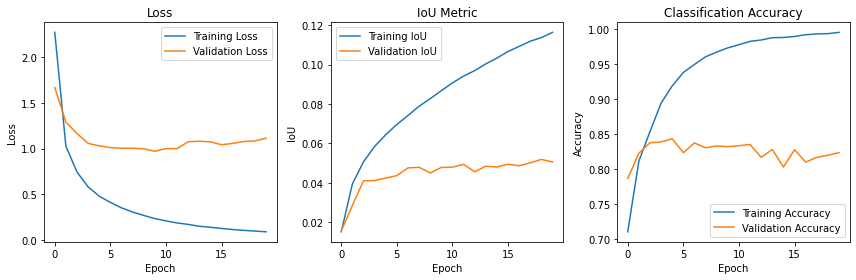

In [23]:
import matplotlib.pyplot as plt

def plot_history(history):
    # Extract metrics from history
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    iou = history.history.get('iou_metric', [])
    val_iou = history.history.get('val_iou_metric', [])
    accuracy = history.history.get('classification_accuracy', [])
    val_accuracy = history.history.get('val_classification_accuracy', [])

    # Plot loss and validation loss
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot IoU and validation IoU
    if iou and val_iou:
        plt.subplot(1, 3, 2)
        plt.plot(iou, label='Training IoU')
        plt.plot(val_iou, label='Validation IoU')
        plt.title('IoU Metric')
        plt.xlabel('Epoch')
        plt.ylabel('IoU')
        plt.legend()

    # Plot Classification Accuracy and validation Accuracy
    if accuracy and val_accuracy:
        plt.subplot(1, 3, 3)
        plt.plot(accuracy, label='Training Accuracy')
        plt.plot(val_accuracy, label='Validation Accuracy')
        plt.title('Classification Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(history)

In [24]:
latest_checkpoint = tf.train.latest_checkpoint(model_dir)
model.load_weights(latest_checkpoint)

### 예측 decode

In [25]:
class DecodePredictions(tf.keras.layers.Layer):

    def __init__(
        self,
        num_classes=8,
        confidence_threshold=0.05,
        nms_iou_threshold=0.5,
        max_detections_per_class=100,
        max_detections=100,
        box_variance=[0.1, 0.1, 0.2, 0.2]
    ):
        super(DecodePredictions, self).__init__()
        self.num_classes = num_classes
        self.confidence_threshold = confidence_threshold
        self.nms_iou_threshold = nms_iou_threshold
        self.max_detections_per_class = max_detections_per_class
        self.max_detections = max_detections

        self._anchor_box = AnchorBox()
        self._box_variance = tf.convert_to_tensor(
            box_variance, dtype=tf.float32
        )

    def _decode_box_predictions(self, anchor_boxes, box_predictions):
        boxes = box_predictions * self._box_variance
        boxes = tf.concat(
            [
                boxes[:, :, :2] * anchor_boxes[:, :, 2:] + anchor_boxes[:, :, :2],
                tf.math.exp(boxes[:, :, 2:]) * anchor_boxes[:, :, 2:],
            ],
            axis=-1,
        )
        boxes_transformed = convert_to_corners(boxes)
        return boxes_transformed

    def call(self, images, predictions):
        image_shape = tf.cast(tf.shape(images), dtype=tf.float32)
        anchor_boxes = self._anchor_box.get_anchors(image_shape[1], image_shape[2])
        box_predictions = predictions[:, :, :4]
        cls_predictions = tf.nn.sigmoid(predictions[:, :, 4:])
        boxes = self._decode_box_predictions(anchor_boxes[None, ...], box_predictions)

        return tf.image.combined_non_max_suppression(
            tf.expand_dims(boxes, axis=2),
            cls_predictions,
            self.max_detections_per_class,
            self.max_detections,
            self.nms_iou_threshold,
            self.confidence_threshold,
            clip_boxes=False,
        )

In [26]:
image = tf.keras.Input(shape=[None, None, 3], name="image")
predictions = model(image, training=False)
detections = DecodePredictions(confidence_threshold=0.5)(image, predictions)
inference_model = tf.keras.Model(inputs=image, outputs=detections)

### 추론 결과 시각화

In [27]:
def visualize_detections(
    image, boxes, classes, scores, figsize=(7, 7), linewidth=1, color=[0, 0, 1]
):
    image = np.array(image, dtype=np.uint8)
    plt.figure(figsize=figsize)
    plt.axis("off")
    plt.imshow(image)
    ax = plt.gca()
    for box, _cls, score in zip(boxes, classes, scores):
        text = "{}: {:.2f}".format(_cls, score)
        x1, y1, x2, y2 = box
        origin_x, origin_y = x1, image.shape[0] - y2 # matplitlib에서 Rectangle와 text를 그릴 때는 좌하단이 원점이고 위로 갈 수록 y값이 커집니다
        w, h = x2 - x1, y2 - y1
        patch = plt.Rectangle(
            [origin_x, origin_y], w, h, fill=False, edgecolor=color, linewidth=linewidth
        )
        ax.add_patch(patch)
        ax.text(
            origin_x,
            origin_y,
            text,
            bbox={"facecolor": color, "alpha": 0.4},
            clip_box=ax.clipbox,
            clip_on=True,
        )
    plt.show()
    return ax

In [28]:
def prepare_image(image):
    image, _, ratio = resize_and_pad_image(image, training=False)
    image = tf.keras.applications.resnet.preprocess_input(image)
    return tf.expand_dims(image, axis=0), ratio

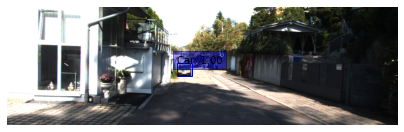

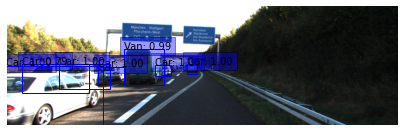

In [29]:
test_dataset = tfds.load("kitti", split="test", data_dir=DATA_PATH)
int2str = dataset_info.features["objects"]["type"].int2str

for sample in test_dataset.take(2):
    image = tf.cast(sample["image"], dtype=tf.float32)
    input_image, ratio = prepare_image(image)
    detections = inference_model.predict(input_image)
    num_detections = detections.valid_detections[0]
    class_names = [
        int2str(int(x)) for x in detections.nmsed_classes[0][:num_detections]
    ]
    visualize_detections(
        image,
        detections.nmsed_boxes[0][:num_detections] / ratio,
        class_names,
        detections.nmsed_scores[0][:num_detections],
    )

### 실험 1 자율주행 보조 시스템
- 정지 및 운행 판단
    - 사람이 있는 경우
    - 차량의 크기가 300px이상인 경우(width or height)
- label
    - car, van, truck, pedestrian, person_sitting, cyclist, tram, misc, dontcare가 0~8까지 순서대로 매핑

In [30]:
HUMAN = [3, 4]
# 자전거는 「도로교통법」에 따라 차로 구분
VEHICLE = [0, 1, 2, 5, 6]

In [31]:
def self_drive_assist(img_path, size_limit=300):
    # 코드 구현
        # 정지조건에 맞으면 return "Stop"
        # 아닌 경우 return "Go"
    # 이미지 불러오기
    image = Image.open(img_path)
    image = np.array(image, dtype=np.float32)
    image = tf.convert_to_tensor(image, dtype=np.float32)
    input_image, ratio = prepare_image(image)
    
    # 예측
    detections = inference_model.predict(input_image)
    num_detections = detections.valid_detections[0]
    classes = detections.nmsed_classes[0][:num_detections]
    
    class_names = [
        int2str(int(x)) for x in detections.nmsed_classes[0][:num_detections]
    ]
    
    boxes = detections.nmsed_boxes[0][:num_detections] / ratio
    scores = detections.nmsed_scores[0][:num_detections]
    
    # 예측 시각화
    visualize_detections(
        image,
        detections.nmsed_boxes[0][:num_detections] / ratio,
        class_names,
        detections.nmsed_scores[0][:num_detections],
    )
    
    for bbox, label in zip(boxes, classes):
        # 사람이 존재할 경우 멈춤
        if label in HUMAN:
            print('human')
            return 'Stop'
        
        # 차량이 300픽셀 이상의 크기일경우 멈춤
        if label in VEHICLE:
            y_min, x_min, y_max, x_max = bbox
            if(((x_max-x_min)>=300) or ((y_max-y_min)>=300)):
                print('vehicle size')
                return 'Stop'
    print('no abstacles')
    return 'Go'

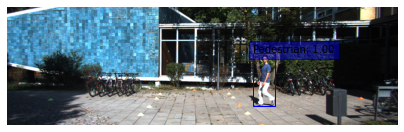

human


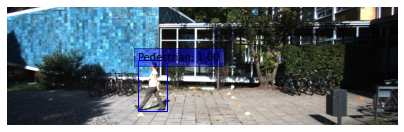

human


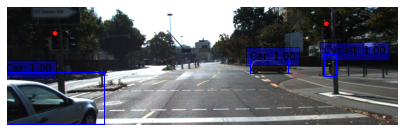

vehicle size


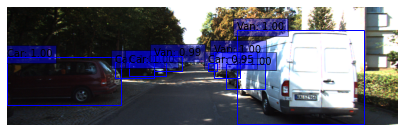

vehicle size


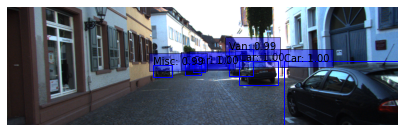

vehicle size


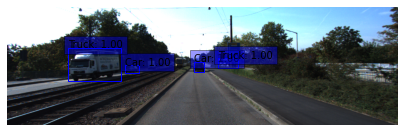

no abstacles


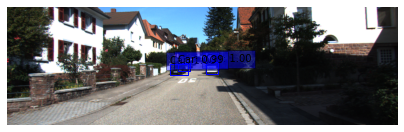

no abstacles


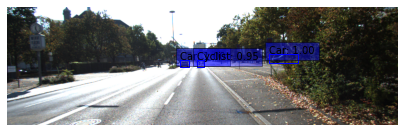

no abstacles


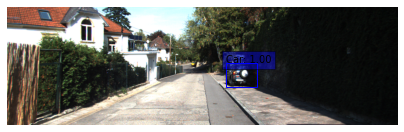

no abstacles


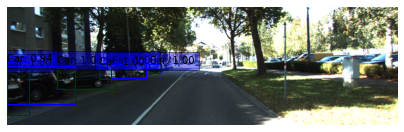

no abstacles
100점입니다.


In [32]:
import os

def test_system(func):
    work_dir = os.getenv('HOME')+'/aiffel/object_detection/data'
    score = 0
    test_set=[
        ("stop_1.png", "Stop"),
        ("stop_2.png", "Stop"),
        ("stop_3.png", "Stop"),
        ("stop_4.png", "Stop"),
        ("stop_5.png", "Stop"),
        ("go_1.png", "Go"),
        ("go_2.png", "Go"),
        ("go_3.png", "Go"),
        ("go_4.png", "Go"),
        ("go_5.png", "Go"),
    ]
    
    for image_file, answer in test_set:
        image_path = work_dir + '/' + image_file
        pred = func(image_path)
        if pred == answer:
            score += 10
    print(f"{score}점입니다.")

test_system(self_drive_assist)

### 실험1 회고
- 100점을 기록하며 목표에 부합하는 결과를 달성했다.
- 하지만 기준이 많이 의문점을 남겼다.
    - 정면의 차는 뒷부분만을 보여주어 실제 거리에 비해 사진에서 차지하는 크기가 작다. 측면의 차량은 옆면도 사진에 노출되기 때문.
    - 사진에서 차량은 직진하고 있음에도 다른 차선의 차량 및 사물도 고려하고 있다.
    - 차종에 관계없이 같은 기준을 차량에 적용하고 있다. 밴의 경우 승용차보다 더 높이가 높고 트럭은 밴보다도 더 높은 높이를 가지고있다.
    - 예측의 신뢰성을 고려하지 않음으로써 잘못된 예측이 발생할 경우에 전혀 대비되어 있지 않다.

### 실험2
- 위의 회고 내용을 바탕으로 예측의 신뢰성, 사물의 위치와 차종을 고려한 시스템을 구성
- 사진 중앙을 기준으로하여 위치를 고려, 멀어질수록 더 적은 영역을 고려하도록 구성

In [33]:
import cv2
def self_drive_assist(img_path, size_limit=300):
    # 코드 구현
        # 정지조건에 맞으면 return "Stop"
        # 아닌 경우 return "Go"
    # 이미지 불러오기
    image = Image.open(img_path)
    image = np.array(image, dtype=np.float32)
    image = tf.convert_to_tensor(image, dtype=np.float32)
    input_image, ratio = prepare_image(image)
    
    # 예측
    detections = inference_model.predict(input_image)
    num_detections = detections.valid_detections[0]
    classes = detections.nmsed_classes[0][:num_detections]
    
    class_names = [
        int2str(int(x)) for x in detections.nmsed_classes[0][:num_detections]
    ]
    
    boxes = detections.nmsed_boxes[0][:num_detections] / ratio
    scores = detections.nmsed_scores[0][:num_detections]
    
    # 이미지 크기
    height, width = input_image.shape[1:3]
    center_x = width / 2
    
    # 예측 시각화
    visualize_detections(
        image,
        detections.nmsed_boxes[0][:num_detections] / ratio,
        class_names,
        detections.nmsed_scores[0][:num_detections],
    )
    
    for bbox, label, score in zip(boxes, classes, scores):
        # confidence score기준 0.4 이하인 바운딩박스 건너뛰기
        if score < 0.4:
            continue
        
        # 바운딩박스 좌표 매핑
        y_min, x_min, y_max, x_max = bbox
        
        # 위치 검사. 밑변이 사진 가로 길이의 3분의 1 꼭지점이 사진 중앙인 사진의 가로중앙에 위치한 삼각형 + 사진 정 중앙이 범위
        left_line = center_x - ((max(0, (y_max - (height / 2))) / (height / 2)) * center_x) / 3
        right_line = center_x + ((max(0, (y_max - (height / 2))) / (height / 2)) * center_x) / 3
        if ((x_min<right_line)and(x_max>left_line)):
            # 검출 위치에 사람이 존재할 경우 멈춤
            if label in HUMAN:
                print('human')
                return 'Stop'
        
            # 검출 위치의 차량이 기준 픽셀 이상의 크기일경우 멈춤
            # 승용차의 경우 보통 1.5m~1.7m, 트럭의 경우 2.2m~3.8m, 밴의 경우 1.7m~2m
            if label == 0:# car 1.6m기준
                if(((x_max-x_min)>=300) or ((y_max-y_min)>=300)):
                    print('vehicle size, car')
                    return 'Stop'
            if label == 1:# van 2m기준
                if(((x_max-x_min)>=375) or ((y_max-y_min)>=375)):
                    print('vehicle size, van')
                    return 'Stop'
            if label == 2:# truck 2.5m기준
                if(((x_max-x_min)>=470) or ((y_max-y_min)>=470)):
                    print('vehicle size, truck')
                    return 'Stop'
            if label == 5:# cyclist
                if(((x_max-x_min)>=300) or ((y_max-y_min)>=300)):
                    print('vehicle size, cyclist')
                    return 'Stop'
            if label == 6:# tram
                if(((x_max-x_min)>=450) or ((y_max-y_min)>=450)):
                    print('vehicle size, tram')
                    return 'Stop'
                
    print('no abstacles')
    return 'Go'

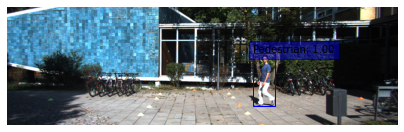

human


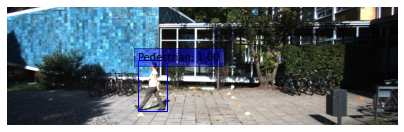

no abstacles


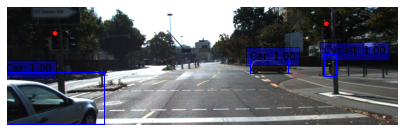

no abstacles


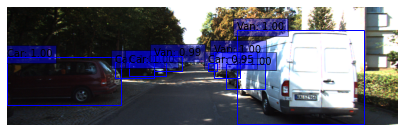

vehicle size, van


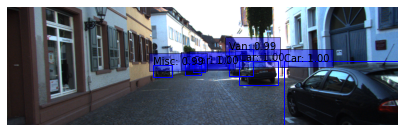

vehicle size, car


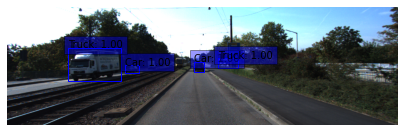

no abstacles


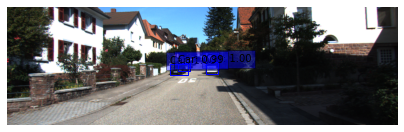

no abstacles


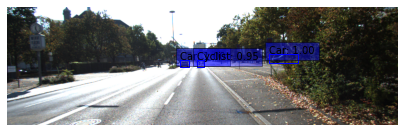

no abstacles


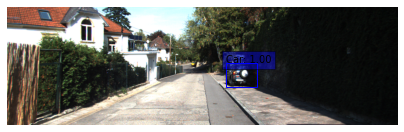

no abstacles


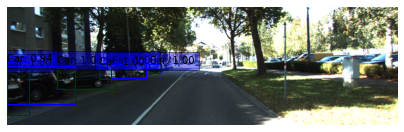

no abstacles


In [34]:
import os

def test_system(func):
    work_dir = os.getenv('HOME')+'/aiffel/object_detection/data'
    test_set=[
        ("stop_1.png", "Stop"),
        ("stop_2.png", "Stop"),
        ("stop_3.png", "Stop"),
        ("stop_4.png", "Stop"),
        ("stop_5.png", "Stop"),
        ("go_1.png", "Go"),
        ("go_2.png", "Go"),
        ("go_3.png", "Go"),
        ("go_4.png", "Go"),
        ("go_5.png", "Go"),
    ]
    
    for image_file, answer in test_set:
        image_path = work_dir + '/' + image_file
        pred = func(image_path)

test_system(self_drive_assist)

### 실험2 회고
- 주행차선과 다른 차선의 차의 경우 고려하지 않는 모습을 관찰할 수 있었고 보행자의 경우에도 사진에서의 도로폭 기준인 중앙 3분의 1(아래 변 기준)부터의 삼각형 범위(사진 중앙지점이 꼭지점)밖의 경우 고려하지 않는 모습을 관찰할 수 있습니다.(1번째 사진과 2번째 사진)
    - 기준은 상황에 맞게 변경할 수 있다는 점에서 실사용성이 좋다고 생각합니다.